<a href="https://colab.research.google.com/github/Kevin20250000000/ML/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --upgrade yahooquery

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
import yfinance as yf
from yahooquery import Ticker
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from io import StringIO
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.tsa.stattools import coint
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import torch

In [ ]:
url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
tables = pd.read_html(url, flavor='bs4')
print(f"totally find  {len(tables)} tables")
print(tables[2].head())

totally find  22 tables
            Company Exchange Symbol                Industry  Date added  \
0                3M     NYSE    MMM            Conglomerate  1976-08-09   
1  American Express     NYSE    AXP      Financial services  1982-08-30   
2             Amgen   NASDAQ   AMGN       Biopharmaceutical  2020-08-31   
3            Amazon   NASDAQ   AMZN               Retailing  2024-02-26   
4             Apple   NASDAQ   AAPL  Information technology  2015-03-19   

                                   Notes Index weighting  
0  As Minnesota Mining and Manufacturing           2.11%  
1                                    NaN           4.37%  
2                                    NaN           3.89%  
3                                    NaN           3.21%  
4                                    NaN           3.25%  


In [ ]:
constituent_stocks = tables[2]
DJI_df = constituent_stocks
DJI_df.head()

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,2.11%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,4.37%
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,3.89%
3,Amazon,NASDAQ,AMZN,Retailing,2024-02-26,NaN,3.21%
4,Apple,NASDAQ,AAPL,Information technology,2015-03-19,NaN,3.25%


In [ ]:
symbols = DJI_df.Symbol.values.tolist()
symbols

['MMM',
 'AXP',
 'AMGN',
 'AMZN',
 'AAPL',
 'BA',
 'CAT',
 'CVX',
 'CSCO',
 'KO',
 'DIS',
 'GS',
 'HD',
 'HON',
 'IBM',
 'JNJ',
 'JPM',
 'MCD',
 'MRK',
 'MSFT',
 'NKE',
 'NVDA',
 'PG',
 'CRM',
 'SHW',
 'TRV',
 'UNH',
 'VZ',
 'V',
 'WMT']

In [ ]:
df_ticker = pd.DataFrame()

for symbol in symbols:
    data = yf.download(symbol, start='2023-01-01', end='2025-03-31', progress=False, auto_adjust=True)

    # solve MultiIndex
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    if not data.empty:
        data["Symbol"] = symbol
        df_ticker = pd.concat([df_ticker, data])

df_ticker.reset_index(inplace=True)
df_ticker.dropna(inplace=True)

df_ticker.to_csv("dji_stocks.csv", index=False)
print("Data saved to dji_stocks.csv")
print(df_ticker.head())

Data saved to dji_stocks.csv
Price       Date      Close       High        Low       Open   Volume Symbol
0     2023-01-03  92.868965  92.997879  91.276537  92.148583  3124909    MMM
1     2023-01-04  94.901199  95.007362  93.050951  93.536264  3312561    MMM
2     2023-01-05  93.240540  94.461402  92.861390  94.188414  3117494    MMM
3     2023-01-06  96.091743  96.402648  93.839594  94.529642  2890732    MMM
4     2023-01-09  96.144821  98.169484  95.629181  96.304069  3434075    MMM


In [ ]:
stock_pairs = list(combinations(symbols, 2))


print(stock_pairs[:5])


print(f"Total pairs: {len(stock_pairs)}")

[('MMM', 'AXP'), ('MMM', 'AMGN'), ('MMM', 'AMZN'), ('MMM', 'AAPL'), ('MMM', 'BA')]
Total pairs: 435


In [ ]:
dji_df_pivot = df_ticker.pivot(index='Date', columns='Symbol', values='Close')

In [ ]:
threshold = 0.05

In [ ]:
cointegrated_pairs = []
for pair in stock_pairs:
    dji_df2 = dji_df_pivot[list(pair)]
    score, pvalue, _ = coint(dji_df2.values[:, 0], dji_df2.values[:, 1])
    if pvalue < threshold:
        cointegrated_pairs.append((pair, pvalue))

# Sort by p-value from small to large
cointegrated_pairs_sorted = sorted(cointegrated_pairs, key=lambda x: x[1])

# Select the top 10 strongest cointegrated pairs
top_10_pairs = cointegrated_pairs_sorted[:10]

print("The top 10 most significant cointegrated stock pairs (with the smallest p-value)：")
for pair, pval in top_10_pairs:
    print(f"{pair}: p-value = {pval:.4f}")

The top 10 most significant cointegrated stock pairs (with the smallest p-value)：
('NVDA', 'PG'): p-value = 0.0006
('AAPL', 'HON'): p-value = 0.0021
('HON', 'NVDA'): p-value = 0.0063
('HON', 'WMT'): p-value = 0.0078
('HON', 'JPM'): p-value = 0.0084
('AXP', 'HON'): p-value = 0.0099
('JNJ', 'MCD'): p-value = 0.0102
('GS', 'HON'): p-value = 0.0158
('GS', 'WMT'): p-value = 0.0180
('AMZN', 'PG'): p-value = 0.0191


In [ ]:
# Save as DataFrame
df_top10_coint = pd.DataFrame(top_10_pairs, columns=["Pair", "p-value"])
df_top10_coint.to_csv("top10_cointegrated_pairs.csv", index=False)

In [ ]:
df_top10_coint

,Pair,p-value
0,"(NVDA, PG)",0.000554
1,"(AAPL, HON)",0.002108
2,"(HON, NVDA)",0.006321
3,"(HON, WMT)",0.007763
4,"(HON, JPM)",0.008378
5,"(AXP, HON)",0.009876
6,"(JNJ, MCD)",0.010222
7,"(GS, HON)",0.015763
8,"(GS, WMT)",0.017966
9,"(AMZN, PG)",0.019135


In [ ]:
spreads = {}

for pair, _ in top_10_pairs:
    stock1, stock2 = pair
    price1 = np.log(dji_df_pivot[stock1])
    price2 = np.log(dji_df_pivot[stock2])
    spread = price1 - price2
    spreads[pair] = spread

    #  Merge the spread into a DataFrame for easier analysis or plotting
    dji_df_pivot[f"{stock1}_{stock2}_spread"] = spread

    print(f"Spread for {stock1} and {stock2} calculated.")

Spread for NVDA and PG calculated.
Spread for AAPL and HON calculated.
Spread for HON and NVDA calculated.
Spread for HON and WMT calculated.
Spread for HON and JPM calculated.
Spread for AXP and HON calculated.
Spread for JNJ and MCD calculated.
Spread for GS and HON calculated.
Spread for GS and WMT calculated.
Spread for AMZN and PG calculated.


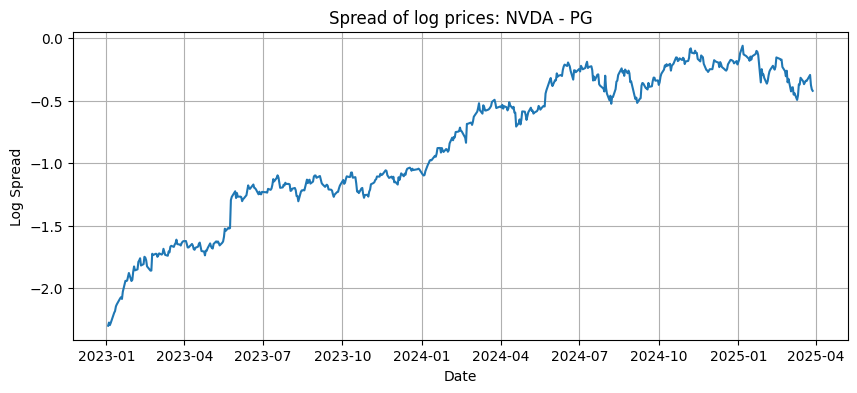

In [ ]:
sample_pair = top_10_pairs[0][0]
spread_series = spreads[sample_pair]

plt.figure(figsize=(10, 4))
plt.plot(spread_series)
plt.title(f"Spread of log prices: {sample_pair[0]} - {sample_pair[1]}")
plt.xlabel("Date")
plt.ylabel("Log Spread")
plt.grid(True)
plt.show()

#I.  Support Vector Machine (SVM)


In [ ]:
# Pairs Trading Using SVM


# Feature engineering

In [ ]:
features_dict = {}

for pair, _ in top_10_pairs:
    stock1, stock2 = pair

    # Take the logarithm of the price
    log_price1 = np.log(dji_df_pivot[stock1])
    log_price2 = np.log(dji_df_pivot[stock2])
    spread = log_price1 - log_price2

    # Feature construction
    asset1_returns = log_price1.diff()
    asset2_returns = log_price2.diff()
    spread_ma5 = spread.rolling(5).mean()
    asset1_volatility = asset1_returns.rolling(20).std()
    asset2_volatility = asset2_returns.rolling(20).std()

    # Merge into DataFrame
    X = pd.DataFrame({
        'Asset1Returns': asset1_returns,
        'Asset2Returns': asset2_returns,
        'SpreadMA5': spread_ma5,
        'Asset1Volatility': asset1_volatility,
        'Asset2Volatility': asset2_volatility
    }).fillna(0)

    y = spread.fillna(0)

    features_dict[pair] = (X, y)

    print(f"Features for pair {stock1}-{stock2} created.")

Features for pair NVDA-PG created.
Features for pair AAPL-HON created.
Features for pair HON-NVDA created.
Features for pair HON-WMT created.
Features for pair HON-JPM created.
Features for pair AXP-HON created.
Features for pair JNJ-MCD created.
Features for pair GS-HON created.
Features for pair GS-WMT created.
Features for pair AMZN-PG created.


In [ ]:
first_pair = top_10_pairs[0][0]
X_sample, y_sample = features_dict[first_pair]

print(X_sample.head())
print(y_sample.head())

            Asset1Returns  Asset2Returns  SpreadMA5  Asset1Volatility  \
Date                                                                    
2023-01-03       0.000000       0.000000   0.000000               0.0   
2023-01-04       0.029867       0.004345   0.000000               0.0   
2023-01-05      -0.033366      -0.012493   0.000000               0.0   
2023-01-06       0.040797       0.023534   0.000000               0.0   
2023-01-09       0.050459      -0.012289  -2.271257               0.0   

            Asset2Volatility  
Date                          
2023-01-03               0.0  
2023-01-04               0.0  
2023-01-05               0.0  
2023-01-06               0.0  
2023-01-09               0.0  
Date
2023-01-03   -2.298606
2023-01-04   -2.273083
2023-01-05   -2.293956
2023-01-06   -2.276693
2023-01-09   -2.213945
dtype: float64


In [ ]:
train_test_split_dict = {}  # Store the training and test sets for each pair of stocks

for pair in top_10_pairs:
    stock_pair = pair[0]
    X, y = features_dict[stock_pair]

    train_size = int(len(y) * 0.8)
    train_X = X.iloc[:train_size]
    test_X = X.iloc[train_size:]
    train_y = y.iloc[:train_size]
    test_y = y.iloc[train_size:]

    train_test_split_dict[stock_pair] = {
        'train_X': train_X,
        'test_X': test_X,
        'train_y': train_y,
        'test_y': test_y
    }

    print(f"Data split for pair {stock_pair[0]}-{stock_pair[1]} complete.")

Data split for pair NVDA-PG complete.
Data split for pair AAPL-HON complete.
Data split for pair HON-NVDA complete.
Data split for pair HON-WMT complete.
Data split for pair HON-JPM complete.
Data split for pair AXP-HON complete.
Data split for pair JNJ-MCD complete.
Data split for pair GS-HON complete.
Data split for pair GS-WMT complete.
Data split for pair AMZN-PG complete.


In [ ]:
test_X.head()

,Asset1Returns,Asset2Returns,SpreadMA5,Asset1Volatility,Asset2Volatility
Date,,,,,
2024-10-15,0.000800,0.006126,0.108108,0.013408,0.008272
2024-10-16,-0.004271,-0.006880,0.106316,0.013434,0.008035
2024-10-17,0.003419,-0.000580,0.103353,0.012771,0.007399
2024-10-18,0.007755,0.000041,0.102139,0.012722,0.006467
2024-10-21,0.000423,-0.010211,0.106065,0.012383,0.006808


# Modeling training

In [ ]:
# Model training and testing using SVM

In [ ]:
svm_results = {}

for pair in top_10_pairs:
    stock_pair = pair[0]
    data = train_test_split_dict[stock_pair]

    train_X = data['train_X']
    test_X = data['test_X']
    train_y = data['train_y']
    test_y = data['test_y']

    svm_model = SVR(kernel='linear')
    svm_model.fit(train_X, train_y)

    train_pred = svm_model.predict(train_X)
    test_pred = svm_model.predict(test_X)

    train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
    test_rmse = np.sqrt(mean_squared_error(test_y, test_pred))

    svm_results[stock_pair] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'model': svm_model,
        'test_pred': test_pred
    }

    print(f"{stock_pair}: Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}")

('NVDA', 'PG'): Train RMSE = 0.2144, Test RMSE = 0.0578
('AAPL', 'HON'): Train RMSE = 0.0608, Test RMSE = 0.0729
('HON', 'NVDA'): Train RMSE = 0.2439, Test RMSE = 0.0556
('HON', 'WMT'): Train RMSE = 0.1091, Test RMSE = 0.1252
('HON', 'JPM'): Train RMSE = 0.0667, Test RMSE = 0.1156
('AXP', 'HON'): Train RMSE = 0.0513, Test RMSE = 0.0881
('JNJ', 'MCD'): Train RMSE = 0.0504, Test RMSE = 0.1037
('GS', 'HON'): Train RMSE = 0.0609, Test RMSE = 0.1206
('GS', 'WMT'): Train RMSE = 0.0726, Test RMSE = 0.0392
('AMZN', 'PG'): Train RMSE = 0.0692, Test RMSE = 0.0961


In [ ]:
def score_fn(model, test_X, spread, type="non_neural_net"):
    # predict spread
    if type == "non_neural_net":
        test_pred = model.predict(test_X)
    else:
        test_pred = model(torch.Tensor(test_X.values)).detach().numpy()

    zscore = (spread - test_pred.mean()) / test_pred.std()

    entry_threshold = 2.0
    exit_threshold = 1.0

    stock1_position = pd.Series(data=0, index=zscore.index)
    stock2_position = pd.Series(data=0, index=zscore.index)

    for i in range(1, len(zscore)):
      if zscore.iloc[i] < -entry_threshold and stock1_position.iloc[i-1] == 0:
        stock1_position.iloc[i] = 1
        stock2_position.iloc[i] = -1
      elif zscore.iloc[i] > entry_threshold and stock2_position.iloc[i-1] == 0:
        stock1_position.iloc[i] = -1
        stock2_position.iloc[i] = 1
      elif abs(zscore.iloc[i]) < exit_threshold:
        stock1_position.iloc[i] = 0
        stock2_position.iloc[i] = 0
      else:
        stock1_position.iloc[i] = stock1_position.iloc[i-1]
        stock2_position.iloc[i] = stock2_position.iloc[i-1]


    stock1_returns = (np.exp(test_X['Asset1Returns']) * stock1_position.shift(1)).fillna(0)
    stock2_returns = (np.exp(test_X['Asset2Returns']) * stock2_position.shift(1)).fillna(0)

    total_returns = stock1_returns + stock2_returns
    cumulative_returns = (1 + total_returns).cumprod()

    # return cumulative_returns[-1], cumulative_returns
    return cumulative_returns.iloc[-1], cumulative_returns

In [ ]:
svm_strategy_returns = {}

for pair in top_10_pairs:
    stocks = pair[0]
    data = train_test_split_dict[stocks]

    test_X = data['test_X']
    test_y = data['test_y']
    spread = test_y
    model = svm_results[stocks]['model']

    # Get the cumulative returns
    final_value, cum_returns = score_fn(model, test_X, spread, type="non_neural_net")

    n_days = len(cum_returns)

    # Calculate annualized return
    annualized_return = (final_value ** (252 / n_days)) - 1


    annualized_return_percent = annualized_return * 100

    svm_strategy_returns[stocks] = annualized_return_percent

    print(f"{stocks}: Annualized Return = {annualized_return_percent:.2f}%")

('NVDA', 'PG'): Annualized Return = 198.31%
('AAPL', 'HON'): Annualized Return = 68.82%
('HON', 'NVDA'): Annualized Return = 187.60%
('HON', 'WMT'): Annualized Return = 0.11%
('HON', 'JPM'): Annualized Return = 13.00%
('AXP', 'HON'): Annualized Return = 49.93%
('JNJ', 'MCD'): Annualized Return = 1.03%
('GS', 'HON'): Annualized Return = 39.89%
('GS', 'WMT'): Annualized Return = 15.97%
('AMZN', 'PG'): Annualized Return = 15.56%


In [ ]:
# Compute the mean annualized return for all 10 pairs
mean_annualized_return = np.mean(list(svm_strategy_returns.values()))
print(f"Mean Annualized Return of the SVM Model for the Top 10 Pairs: {mean_annualized_return:.2f}%")

Mean Annualized Return of the SVM Model for the Top 10 Pairs: 59.02%


# Visualization - SVM

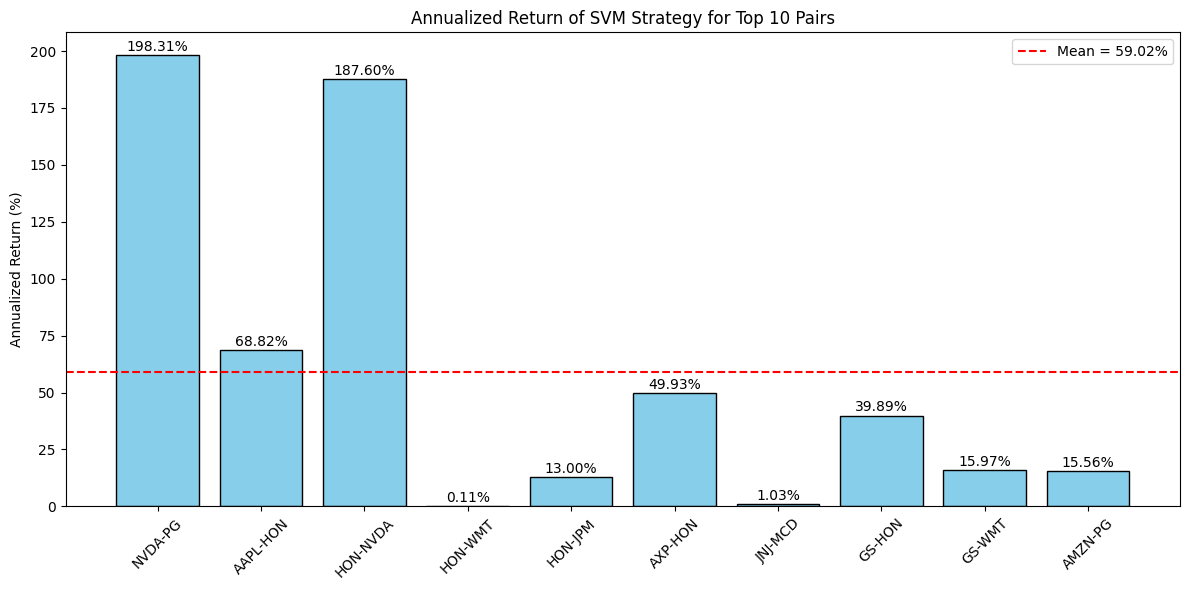

In [ ]:
pair_labels = [f"{p[0]}-{p[1]}" if isinstance(p, (list, tuple)) else str(p) for p in pairs]

plt.figure(figsize=(12, 6))
bars = plt.bar(pair_labels, returns, color='skyblue', edgecolor='black')
plt.axhline(mean_annualized_return, color='red', linestyle='--', label=f'Mean = {mean_annualized_return:.2f}%')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom')

plt.title('Annualized Return of SVM Strategy for Top 10 Pairs')
plt.xticks(rotation=45)
plt.ylabel('Annualized Return (%)')
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-114-72440719e7c4>:12: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(cum_returns.index, cum_returns.values, label=stocks)
<ipython-input-114-72440719e7c4>:12: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(cum_returns.index, cum_returns.values, label=stocks)
<ipython-input-114-72440719e7c4>:12: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(cum_returns.index, cum_returns.values, label=stocks)
<ipython-i

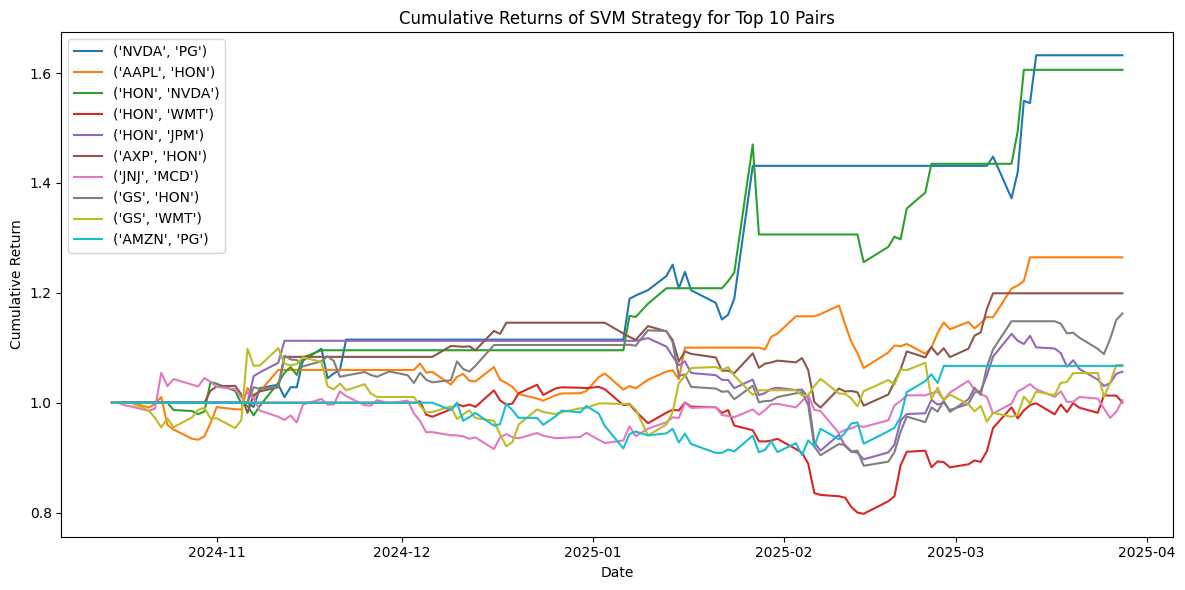

In [ ]:
plt.figure(figsize=(12, 6))

for pair in top_10_pairs:
    stocks = pair[0]
    data = train_test_split_dict[stocks]
    test_X = data['test_X']
    test_y = data['test_y']
    spread = test_y
    model = svm_results[stocks]['model']

    _, cum_returns = score_fn(model, test_X, spread, type="non_neural_net")
    plt.plot(cum_returns.index, cum_returns.values, label=stocks)

plt.title('Cumulative Returns of SVM Strategy for Top 10 Pairs')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.tight_layout()
plt.show()

# II. Random Forest

In [ ]:
# Pairs Trading Using Random Forest
# Model training and testing using random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_strategy_returns = {}

for pair in top_10_pairs:
    stocks = pair[0]
    data = train_test_split_dict[stocks]

    train_X = data['train_X']
    train_y = data['train_y']
    test_X = data['test_X']
    test_y = data['test_y']
    spread = test_y

    # Create and train a random forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(train_X, train_y)

    # output RMSE
    train_pred = rf_model.predict(train_X)
    test_pred = rf_model.predict(test_X)
    print(f"{stocks}:")
    print("  Train RMSE:", np.sqrt(mean_squared_error(train_y, train_pred)))
    print("  Test RMSE :", np.sqrt(mean_squared_error(test_y, test_pred)))


    final_value, cum_returns = score_fn(rf_model, test_X, spread, type="non_neural_net")


    n_days = len(cum_returns)
    annualized_return = (final_value ** (252 / n_days)) - 1
    annualized_return_percent = annualized_return * 100

    rf_strategy_returns[stocks] = annualized_return_percent
    print(f"  Annualized Return: {annualized_return_percent:.2f}%\n")

('NVDA', 'PG'):
  Train RMSE: 0.011745487878736275
  Test RMSE : 0.16343979316364246
  Annualized Return: 0.00%

('AAPL', 'HON'):
  Train RMSE: 0.005468591588265252
  Test RMSE : 0.02163537694102848
  Annualized Return: 35.48%

('HON', 'NVDA'):
  Train RMSE: 0.011511275232080039
  Test RMSE : 0.042702357799628624
  Annualized Return: 190.80%

('HON', 'WMT'):
  Train RMSE: 0.004860441492694264
  Test RMSE : 0.10625872878720254
  Annualized Return: 19.95%

('HON', 'JPM'):
  Train RMSE: 0.004856958201776707
  Test RMSE : 0.09112113193116914
  Annualized Return: 30.08%

('AXP', 'HON'):
  Train RMSE: 0.00622520058854598
  Test RMSE : 0.058929417149303887
  Annualized Return: 76.22%

('JNJ', 'MCD'):
  Train RMSE: 0.004205948171922879
  Test RMSE : 0.0347102777845694
  Annualized Return: 50.15%

('GS', 'HON'):
  Train RMSE: 0.005086171663921531
  Test RMSE : 0.10640978286027195
  Annualized Return: 37.35%

('GS', 'WMT'):
  Train RMSE: 0.005819841311944784
  Test RMSE : 0.020181880215952
  Ann

In [ ]:
# Compute the mean annualized return for all 10 pairs
mean_annualized_return = np.mean(list(rf_strategy_returns.values()))
print(f"Mean Annualized Return of the Random Forest Model for the Top 10 Pairs: {mean_annualized_return:.2f}%")

Mean Annualized Return of the Random Forest Model for the Top 10 Pairs: 61.48%


# Visualization - Random Forest

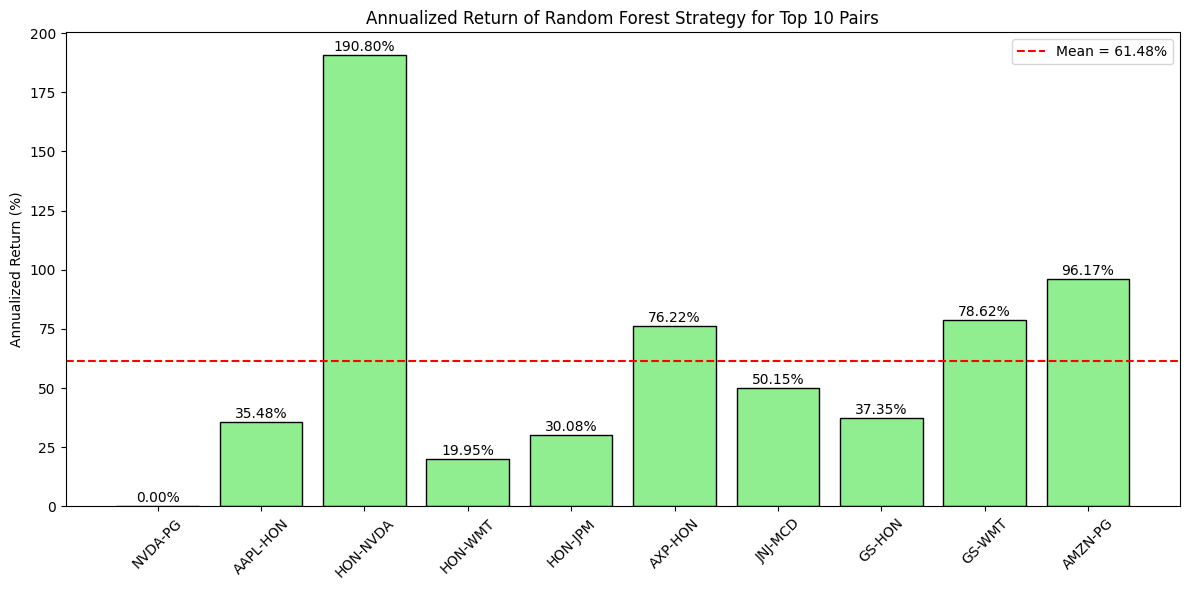

In [ ]:
pairs = list(rf_strategy_returns.keys())
returns = list(rf_strategy_returns.values())
pair_labels = [f"{p[0]}-{p[1]}" if isinstance(p, (list, tuple)) else str(p) for p in pairs]


mean_return = np.mean(returns)

plt.figure(figsize=(12, 6))
bars = plt.bar(pair_labels, returns, color='lightgreen', edgecolor='black')
plt.axhline(mean_return, color='red', linestyle='--', label=f'Mean = {mean_return:.2f}%')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom')

plt.title('Annualized Return of Random Forest Strategy for Top 10 Pairs')
plt.ylabel('Annualized Return (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#  III. Neural Network

In [ ]:
# Pairs Trading Using Neural Network
# Model training and testing using Neural Network

In [ ]:
# Convert data to PyTorch tensors
train_X_ts = torch.Tensor(train_X.values)
train_y_ts = torch.Tensor(train_y).view(-1, 1)
test_X_ts = torch.Tensor(test_X.values)
test_y_ts = torch.Tensor(test_y).view(-1, 1)

<ipython-input-96-1d13279f6bcf>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_ts = torch.Tensor(train_y).view(-1, 1)
<ipython-input-96-1d13279f6bcf>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_y_ts = torch.Tensor(test_y).view(-1, 1)


In [ ]:
import torch.nn as nn

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_X.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
from torchsummary import summary

# Create an instance of the neural network model
nn_model = Net()
# print the summary of the customized neural network
summary(nn_model, input_size=(1, train_X.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             384
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 32]           2,080
              ReLU-4                [-1, 1, 32]               0
            Linear-5                 [-1, 1, 1]              33
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [ ]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

# Train the model
for epoch in range(100):
    optimizer.zero_grad()
    outputs = nn_model(train_X_ts)
    loss = criterion(outputs, train_y_ts)
    loss.backward()
    optimizer.step()

    # Print the loss for every 10 epochs
    if epoch % 10 == 0:
        print("Epoch {}, Loss: {:.4f}".format(epoch, loss.item()))

# evaluate the model on the training and testing set
train_pred = nn_model(train_X_ts).detach().numpy()
print("training rmse: ", np.sqrt(mean_squared_error(train_y_ts, train_pred)))
test_pred = nn_model(test_X_ts).detach().numpy()
print("test rmse: ", np.sqrt(mean_squared_error(test_y_ts, test_pred)))

Epoch 0, Loss: 0.0327
Epoch 10, Loss: 0.0213
Epoch 20, Loss: 0.0156
Epoch 30, Loss: 0.0102
Epoch 40, Loss: 0.0058
Epoch 50, Loss: 0.0033
Epoch 60, Loss: 0.0027
Epoch 70, Loss: 0.0028
Epoch 80, Loss: 0.0027
Epoch 90, Loss: 0.0026
training rmse:  0.05107615651380652
test rmse:  0.02781969139867514


In [ ]:
from torchsummary import summary

# Neural Network Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_X.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize neural network model
nn_model = Net()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

# Function to calculate RMSE and Annualized Return
def compute_rmse_and_annualized_return(nn_model, train_X_ts, train_y_ts, test_X_ts, test_y_ts, spread):
    # Evaluate the model on training and test data
    train_pred = nn_model(train_X_ts).detach().numpy()
    test_pred = nn_model(test_X_ts).detach().numpy()

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(train_y_ts, train_pred))
    test_rmse = np.sqrt(mean_squared_error(test_y_ts, test_pred))

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")

    # Calculate cumulative returns and annualized return
    # Using strategy function similar to Random Forest strategy
    zscore = (spread - test_pred.mean()) / test_pred.std()

    stock1_position = pd.Series(data=0, index=zscore.index)
    stock2_position = pd.Series(data=0, index=zscore.index)

    entry_threshold = 1.0
    exit_threshold = 0.5

    for i in range(1, len(zscore)):
        if zscore.iloc[i] < -entry_threshold and stock1_position.iloc[i-1] == 0:
            stock1_position.iloc[i] = 1
            stock2_position.iloc[i] = -1
        elif zscore.iloc[i] > entry_threshold and stock2_position.iloc[i-1] == 0:
            stock1_position.iloc[i] = -1
            stock2_position.iloc[i] = 1
        elif abs(zscore.iloc[i]) < exit_threshold:
            stock1_position.iloc[i] = 0
            stock2_position.iloc[i] = 0
        else:
            stock1_position.iloc[i] = stock1_position.iloc[i-1]
            stock2_position.iloc[i] = stock2_position.iloc[i-1]

    # Assuming 'spread' contains the returns for both stocks in the pair
    # Convert tensor to NumPy array
    asset1_returns = test_X_ts[:, 0].detach().numpy()  # Assuming asset 1 returns are in the first column
    asset2_returns = test_X_ts[:, 1].detach().numpy()  # Assuming asset 2 returns are in the second column

    # Calculate stock returns based on positions
    stock1_returns = (np.exp(asset1_returns) * stock1_position.shift(1)).fillna(0)
    stock2_returns = (np.exp(asset2_returns) * stock2_position.shift(1)).fillna(0)

    total_returns = stock1_returns + stock2_returns
    cumulative_returns = (1 + total_returns).cumprod()

    final_value = cumulative_returns.iloc[-1]
    n_days = len(cumulative_returns)
    annualized_return = (final_value ** (252 / n_days)) - 1
    annualized_return_percent = annualized_return * 100

    return train_rmse, test_rmse, annualized_return_percent

# Initialize dictionary to store results
nn_strategy_returns = {}

# Iterate over top_10_pairs to calculate RMSE and annualized returns
for pair in top_10_pairs:
    stocks = pair[0]
    data = train_test_split_dict[stocks]

    train_X = data['train_X']
    train_y = data['train_y']
    test_X = data['test_X']
    test_y = data['test_y']
    spread = test_y  # This is the spread (target variable)

    # Convert data to PyTorch tensors
    train_X_ts = torch.Tensor(train_X.values)
    train_y_ts = torch.Tensor(train_y).view(-1, 1)
    test_X_ts = torch.Tensor(test_X.values)
    test_y_ts = torch.Tensor(test_y).view(-1, 1)

    # Train the neural network model
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = nn_model(train_X_ts)
        loss = criterion(outputs, train_y_ts)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    # Compute RMSE and annualized return
    train_rmse, test_rmse, annualized_return_percent = compute_rmse_and_annualized_return(
        nn_model, train_X_ts, train_y_ts, test_X_ts, test_y_ts, spread
    )

    # Store results in dictionary
    nn_strategy_returns[stocks] = annualized_return_percent
    print(f"{stocks}: Annualized Return: {annualized_return_percent:.2f}%\n")

# Output results
print("Neural Network Strategy Returns:")
for stock, annualized_return in nn_strategy_returns.items():
    print(f"{stock}: {annualized_return:.2f}%")

<ipython-input-100-b974c72624e3>:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_ts = torch.Tensor(train_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_y_ts = torch.Tensor(test_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_ts = torch.Tensor(train_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:105: FutureW

Epoch 0, Loss: 1.0931
Epoch 10, Loss: 0.8434
Epoch 20, Loss: 0.6098
Epoch 30, Loss: 0.3661
Epoch 40, Loss: 0.1708
Epoch 50, Loss: 0.0939
Epoch 60, Loss: 0.0889
Epoch 70, Loss: 0.0769
Epoch 80, Loss: 0.0655
Epoch 90, Loss: 0.0586
Training RMSE: 0.2271
Test RMSE: 0.2893
('NVDA', 'PG'): Annualized Return: 12.29%

Epoch 0, Loss: 0.1841
Epoch 10, Loss: 0.0860
Epoch 20, Loss: 0.0253
Epoch 30, Loss: 0.0100
Epoch 40, Loss: 0.0077
Epoch 50, Loss: 0.0076
Epoch 60, Loss: 0.0072
Epoch 70, Loss: 0.0066
Epoch 80, Loss: 0.0059
Epoch 90, Loss: 0.0053
Training RMSE: 0.0691
Test RMSE: 0.0872
('AAPL', 'HON'): Annualized Return: 12.41%

Epoch 0, Loss: 1.5568
Epoch 10, Loss: 0.9859
Epoch 20, Loss: 0.3288
Epoch 30, Loss: 0.0722


<ipython-input-100-b974c72624e3>:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_ts = torch.Tensor(train_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_y_ts = torch.Tensor(test_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_ts = torch.Tensor(train_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:105: FutureW

Epoch 40, Loss: 0.1032
Epoch 50, Loss: 0.0719
Epoch 60, Loss: 0.0670
Epoch 70, Loss: 0.0651
Epoch 80, Loss: 0.0617
Epoch 90, Loss: 0.0601
Training RMSE: 0.2413
Test RMSE: 0.2243
('HON', 'NVDA'): Annualized Return: 11.21%

Epoch 0, Loss: 0.0112
Epoch 10, Loss: 0.0098
Epoch 20, Loss: 0.0096
Epoch 30, Loss: 0.0093
Epoch 40, Loss: 0.0091
Epoch 50, Loss: 0.0088
Epoch 60, Loss: 0.0086
Epoch 70, Loss: 0.0084
Epoch 80, Loss: 0.0082
Epoch 90, Loss: 0.0080
Training RMSE: 0.0882
Test RMSE: 0.0955
('HON', 'WMT'): Annualized Return: 4.08%

Epoch 0, Loss: 0.2039
Epoch 10, Loss: 0.1014
Epoch 20, Loss: 0.0317
Epoch 30, Loss: 0.0101
Epoch 40, Loss: 0.0067
Epoch 50, Loss: 0.0057
Epoch 60, Loss: 0.0044
Epoch 70, Loss: 0.0039
Epoch 80, Loss: 0.0034


<ipython-input-100-b974c72624e3>:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_ts = torch.Tensor(train_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_y_ts = torch.Tensor(test_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_ts = torch.Tensor(train_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:105: FutureW

Epoch 90, Loss: 0.0030
Training RMSE: 0.0524
Test RMSE: 0.0919
('HON', 'JPM'): Annualized Return: 3.70%

Epoch 0, Loss: 0.0073
Epoch 10, Loss: 0.0036
Epoch 20, Loss: 0.0024
Epoch 30, Loss: 0.0020
Epoch 40, Loss: 0.0015
Epoch 50, Loss: 0.0013
Epoch 60, Loss: 0.0012
Epoch 70, Loss: 0.0012
Epoch 80, Loss: 0.0012
Epoch 90, Loss: 0.0012
Training RMSE: 0.0343
Test RMSE: 0.0193
('AXP', 'HON'): Annualized Return: 74.40%

Epoch 0, Loss: 0.0071
Epoch 10, Loss: 0.0014
Epoch 20, Loss: 0.0020
Epoch 30, Loss: 0.0014
Epoch 40, Loss: 0.0013
Epoch 50, Loss: 0.0013
Epoch 60, Loss: 0.0012
Epoch 70, Loss: 0.0012
Epoch 80, Loss: 0.0011
Epoch 90, Loss: 0.0011
Training RMSE: 0.0326
Test RMSE: 0.0206
('JNJ', 'MCD'): Annualized Return: 59.86%

Epoch 0, Loss: 0.0162
Epoch 10, Loss: 0.0028
Epoch 20, Loss: 0.0038


<ipython-input-100-b974c72624e3>:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_ts = torch.Tensor(train_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_y_ts = torch.Tensor(test_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_ts = torch.Tensor(train_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:105: FutureW

Epoch 30, Loss: 0.0029
Epoch 40, Loss: 0.0026
Epoch 50, Loss: 0.0025
Epoch 60, Loss: 0.0024
Epoch 70, Loss: 0.0024
Epoch 80, Loss: 0.0023
Epoch 90, Loss: 0.0022
Training RMSE: 0.0469
Test RMSE: 0.0259
('GS', 'HON'): Annualized Return: 35.81%

Epoch 0, Loss: 0.0363
Epoch 10, Loss: 0.0324
Epoch 20, Loss: 0.0316
Epoch 30, Loss: 0.0305
Epoch 40, Loss: 0.0295


<ipython-input-100-b974c72624e3>:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_ts = torch.Tensor(train_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_y_ts = torch.Tensor(test_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_ts = torch.Tensor(train_y).view(-1, 1)
<ipython-input-100-b974c72624e3>:105: FutureW

Epoch 50, Loss: 0.0286
Epoch 60, Loss: 0.0276
Epoch 70, Loss: 0.0267
Epoch 80, Loss: 0.0260
Epoch 90, Loss: 0.0255
Training RMSE: 0.1582
Test RMSE: 0.0179
('GS', 'WMT'): Annualized Return: 122.05%

Epoch 0, Loss: 0.0717
Epoch 10, Loss: 0.0185
Epoch 20, Loss: 0.0047
Epoch 30, Loss: 0.0055
Epoch 40, Loss: 0.0028
Epoch 50, Loss: 0.0030
Epoch 60, Loss: 0.0028
Epoch 70, Loss: 0.0027
Epoch 80, Loss: 0.0027
Epoch 90, Loss: 0.0027
Training RMSE: 0.0520
Test RMSE: 0.0482
('AMZN', 'PG'): Annualized Return: 136.06%

Neural Network Strategy Returns:
('NVDA', 'PG'): 12.29%
('AAPL', 'HON'): 12.41%
('HON', 'NVDA'): 11.21%
('HON', 'WMT'): 4.08%
('HON', 'JPM'): 3.70%
('AXP', 'HON'): 74.40%
('JNJ', 'MCD'): 59.86%
('GS', 'HON'): 35.81%
('GS', 'WMT'): 122.05%
('AMZN', 'PG'): 136.06%


In [ ]:
# Compute the mean annualized return for all 10 pairs
mean_annualized_return = np.mean(list(nn_strategy_returns.values()))
print(f"Mean Annualized Return of the Neural Networkt Model for the Top 10 Pairs: {mean_annualized_return:.2f}%")

Mean Annualized Return of the Neural Networkt Model for the Top 10 Pairs: 47.19%


# Visualization - Neural Network

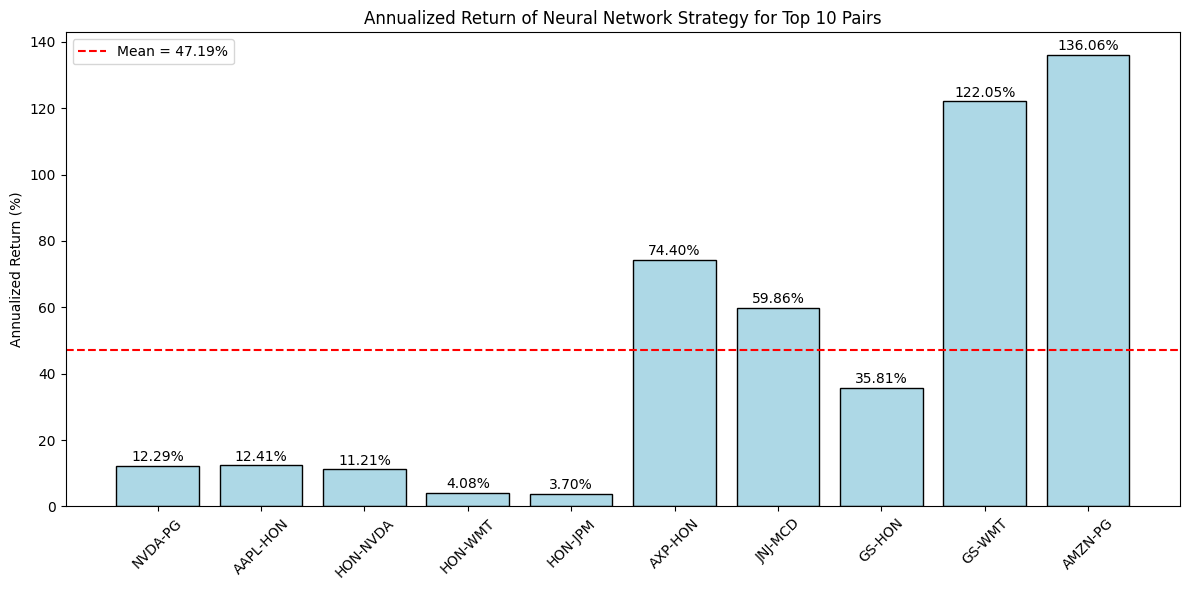

In [ ]:
pairs = list(nn_strategy_returns.keys())
returns = list(nn_strategy_returns.values())
pair_labels = [f"{p[0]}-{p[1]}" if isinstance(p, (list, tuple)) else str(p) for p in pairs]

mean_return = np.mean(returns)

plt.figure(figsize=(12, 6))
bars = plt.bar(pair_labels, returns, color='lightblue', edgecolor='black')
plt.axhline(mean_return, color='red', linestyle='--', label=f'Mean = {mean_return:.2f}%')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom')

plt.title('Annualized Return of Neural Network Strategy for Top 10 Pairs')
plt.ylabel('Annualized Return (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()